In [2]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans

from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from IPython.display import display, Image

import xgboost as xgb

use_xgb=False #disable for speed

from subprocess import check_output
datadir="./input/"
print(check_output(["ls", datadir]).decode("utf8"))

%matplotlib inline  


test.csv.zip
train.csv.zip



In [3]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        
def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

# XGB!

def xgbfit(X_train,y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    

    xgb_params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.075,
        'objective': 'reg:linear',
        'max_depth': 6,
        'num_parallel_tree': 1,
        'min_child_weight': 1,
        'eval_metric': 'mae',
    }

    start_time = time.time()
    res = xgb.cv(xgb_params, dtrain, num_boost_round=750, nfold=4, seed=42, stratified=False,
                 early_stopping_rounds=15, verbose_eval=100, show_stdv=True, maximize=False)
    print("fit time:{}s".format(round((time.time()-start_time), 3) ))

    best_nrounds = res.shape[0] - 1
    cv_mean = res.iloc[-1, 0]
    cv_std = res.iloc[-1, 1]
    print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
    # XGB Train!
    start_time = time.time()
    gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
    print("Train time:{}s".format(round((time.time()-start_time), 3) ))
    return gbdt

In [4]:
data = loadData(datadir,'train.csv.zip')
display(data.info())
display(data.head(5))

test_data= loadData(datadir,'test.csv.zip') 
display(test_data.info())
display(test_data.head(5))

loading: ./input/train.csv.zip
Dataset has 188318 samples with 132 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


loading: ./input/test.csv.zip
Dataset has 125546 samples with 131 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


###  Pre Proccessing

In [5]:
# combine the two frames so we can encode the labels!
test_data['loss']=0

lengthofData=len(data)
lengthoftest_data=len(test_data)

print("data:",lengthofData)
print("test:",lengthoftest_data)

combineddata=pd.concat([data,test_data])
lengthofcombined=len(combineddata)
print("combined:",lengthofcombined)

# the categorical data that we need in a number format
combineddata=LabelEncoder(combineddata)

# time to split the data back apart!
data=combineddata.iloc[:lengthofData].copy()
test_data=combineddata.iloc[lengthofData:].copy()
test_data.drop(['loss'],1,inplace=True) # didn't have this column before, make it go away!


x_test = test_data.copy()
x_test.drop(['id'],1,inplace=True)

# we don't want the ID columns in X, and of course not loss either
x=data.drop(['id','loss'],1)
# loss is our label
y=data['loss']

#minmax scaler
scaler= MinMaxScaler() 
x = scaler.fit_transform(x)
x_test_data = scaler.fit_transform(x_test)

#display(x[:5])
#display(y.head(5))

print("Pre-Processing done")
print("data:",len(x))
print("labels:",len(y))
print("test:",len(x_test_data))


('data:', 188318)
('test:', 125546)
('combined:', 313864)
Pre-Processing done
('data:', 188318)
('labels:', 188318)
('test:', 125546)


### pick our sklearn regressors, and do some param optimizations

In [6]:
regressor_w_grid=[] # a list of regressions to use
#regrList.append([LinearRegression()])
regressor_w_grid.append([ExtraTreesRegressor(n_jobs = -1,),
                         dict(n_estimators=[5,7,10,25,50,500],
                         max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([Ridge(),
                         dict(alpha=[.5,1,2,4,40,400])])
regressor_w_grid.append([RandomForestRegressor(#criterion = 'mae',
                                      n_jobs =-1, 
                                      random_state=42),
                        dict(n_estimators=[5,7,10,25,50,500],
                             max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([KNeighborsRegressor(n_jobs = -1),
                        dict(n_neighbors=[2,5,7],
                             leaf_size =[3,15,30,50])])
#regrList.append([SVR(), dict()]) # oh my so slow! and bad initial scores



regrList=np.array(regressor_w_grid).T[0]
paramater_grid=np.array(regressor_w_grid).T[1]
print regrList
print paramater_grid

print("number of scikitlearn regressors to use:",len(regrList))

[ ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')]
[ {'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [5, 7,

In [ ]:
start_time0 = time.time()
#  train/validation split
X_train, X_validation, y_train, y_validation = train_test_split( x,
                                                                y,
                                                               test_size=0.85,
                                                                random_state=42)
display("sample train data size:{}".format(len(y_train)))

from sklearn.externals import joblib
for i in range(len(regrList)):
    start_time = time.time()
    print("In:{}".format(regrList[i]))
    filename= 'grid_regr{}.pkl'.format(i)
    if os.path.isfile(filename):
        print filename," exists, importing "
        regrList[i]=joblib.load(filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regrList[i], param_grid= paramater_grid[i], n_jobs= -1, scoring=make_scorer(mean_absolute_error)) 
        grid_search.fit(X_train,y_train)
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regrList[i].set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regrList[i],filename) 

print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   




### Stacking Layer 1, train and predict for layer 2

Split the data into k-folds(divisions). train the regressors on each combination of k-1 folds, and then predict on the held-out fold. Preserve the prediction of each regressor for the next layer.

In [7]:
#prepare the fold divisions

data_size=x.shape[0]
print "size of train data:",data_size
folds=[]
num_folds=5
fold_start=0
for k in range(num_folds-1):
    fold_end=((data_size/num_folds)*(k+1))
    folds.append((fold_start,fold_end))
    fold_start=fold_end
folds.append((fold_start,data_size))
print "folds at:",folds
print "fold size:", (data_size/num_folds)
print "train size:",(data_size/num_folds)*(num_folds-1)

count=0
for i in folds:
    count+=i[1]-i[0]
print count

size of train data: 188318
folds at: [(0, 37663), (37663, 75326), (75326, 112989), (112989, 150652), (150652, 188318)]
fold size: 37663
train size: 150652
188318


In [8]:
x_layer2=[]
start_time0 = time.time()
MAE_tracking=[]

for fold_start,fold_end in folds:
    print("Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
    start_time1 = time.time()
    fold_result=[]
    
    X_test = x[fold_start:fold_end].copy()
    y_test = y[fold_start:fold_end].copy()
    X_train=np.concatenate((x[:fold_start], x[fold_end:]), axis=0)
    y_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
    print "\nfolding! len test {}, len train {}".format(len(X_test),len(X_train))
    
    for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
        start_time = time.time()
        regrList[i].fit(X_train,y_train)
        print("\nfit time:{}s".format(round((time.time()-start_time), 3) ))

        start_time = time.time()
        print(regrList[i])
        curr_predict=regrList[i].predict(X_test)
        if fold_result == []:
            fold_result = np.array(curr_predict.copy())
        else:
            fold_result = np.column_stack((fold_result,curr_predict))
        
        print("predict time:{}s".format(round((time.time()-start_time), 3) ))
        #show some stats on that last regressions run
        MAE=np.mean(abs(curr_predict - y_test))
        MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,i),MAE])
        print("Mean abs error: {:.2f}".format(MAE))
        print("Score: {:.2f}".format(regrList[i].score(X_test, y_test)))
    
    #XGB -- it doesn't fit the pattern of scikit, so do it seperatly
    
    if use_xgb == True:
        dtest = xgb.DMatrix(X_test)
        gbdt=xgbfit(X_train,y_train)

        # now do a prediction and spit out a score(MAE) that means something
        start_time = time.time()
        curr_predict=gbdt.predict(dtest)
        fold_result = np.column_stack((fold_result,curr_predict))   
        MAE=np.mean(abs(curr_predict - y_test))
        MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,'XGB'),MAE])
        print("XGB Mean abs error: {:.2f}".format(MAE))
        print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))

    if x_layer2 == []:
        x_layer2=fold_result
    else:
        x_layer2=np.append(x_layer2,fold_result,axis=0)
        
    print "--layer2 length:",len(x_layer2)
    print "--layer2 shape:",np.shape(x_layer2)
    print("Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   
print("Full run time:{}s".format(round((time.time()-start_time0), 3) ))   


Fold:0 to 37663 of: 188318

folding! len test 37663, len train 150655

fit time:23.995s
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
predict time:0.215s
Mean abs error: 1327.36
Score: 0.46

fit time:3.408s
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
predict time:0.012s
Mean abs error: 1335.61
Score: 0.49


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



fit time:26.723s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
predict time:0.224s
Mean abs error: 1328.68
Score: 0.46

fit time:83.938s
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
predict time:293.368s
Mean abs error: 1374.38
Score: 0.40
--layer2 length: 37663
--layer2 shape: (37663, 4)
Fold run time:728.843s
Fold:37663 to 75326 of: 188318

folding! len test 37663, len train 150655

fit time:23.963s
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:51: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



fit time:25.566s
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
predict time:0.217s
Mean abs error: 1323.98
Score: 0.47

fit time:3.454s
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
predict time:0.011s
Mean abs error: 1330.79
Score: 0.48

fit time:27.954s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
predict time:0.237s
Mean abs error: 1317.28
Score: 0.48

fit time:82.1


### train layer 2

In [9]:
print len(x_layer2)
print len(y)

#  train/validation split
X_layer2_train, X_layer2_validation, y_layer2_train, y_layer2_validation = train_test_split( x_layer2,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)
layer2_regr=LinearRegression()

layer2_regr.fit(X_layer2_train,y_layer2_train)

layer2_predict=layer2_regr.predict(X_layer2_validation)

#show some stats on that last regressions run    
MAE=np.mean(abs(layer2_predict - y_layer2_validation))
MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
print("Mean abs error: {:.2f}".format(MAE))
print("Score: {:.2f}".format(layer2_regr.score(X_layer2_validation, y_layer2_validation)))


#with LinearReg: Mean abs error: 1238.52

188318
188318
Mean abs error: 1233.34
Score: 0.53


In [10]:
# The XGB version of layer 2
print len(x_layer2)
print len(y)

#  train/validation split
X_layer2_train, X_layer2_validation, y_layer2_train, y_layer2_validation = train_test_split( x_layer2,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)
#XGB -- it doesn't fit the pattern of scikit, so do it seperatly
dtest = xgb.DMatrix(X_layer2_validation)
layer2_gbdt=xgbfit(X_layer2_train,y_layer2_train)

# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
MAE=np.mean(abs(layer2_gbdt.predict(dtest) - y_layer2_validation))
MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
print("XGB Mean abs error: {:.2f}".format(MAE))
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
#with LinearReg: XGB Mean abs error: 1205.77

188318
188318
[0]	train-mae:2810.82+3.85525	test-mae:2810.83+12.0151
fit time:5.969s
CV-Mean: 1204.1655575+5.2453239012
Train time:1.229s
XGB Mean abs error: 1201.00
XGB predict time:0.028s


### MAE tracking:

[['run:0-37663:0' 'run:0-37663:1' 'run:0-37663:2' 'run:0-37663:3'
  'run:37663-75326:0' 'run:37663-75326:1' 'run:37663-75326:2'
  'run:37663-75326:3' 'run:75326-112989:0' 'run:75326-112989:1'
  'run:75326-112989:2' 'run:75326-112989:3' 'run:112989-150652:0'
  'run:112989-150652:1' 'run:112989-150652:2' 'run:112989-150652:3'
  'run:150652-188318:0' 'run:150652-188318:1' 'run:150652-188318:2'
  'run:150652-188318:3' 'run:linearLayer2' 'run:XGBLayer2']
 ['1327.36027305' '1335.6109609' '1328.67511744' '1374.37524594'
  '1308.1138336' '1322.16612723' '1302.41998256' '1371.70692547'
  '1323.97581982' '1330.79485737' '1317.28013905' '1392.41162106'
  '1326.35518582' '1338.83235314' '1323.88590739' '1389.28851228'
  '1314.57310389' '1326.80644028' '1311.62821712' '1367.2665912'
  '1233.34382615' '1201.0000153']]


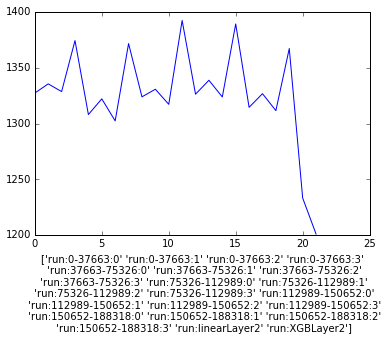

In [11]:

MAE_tracking_graph=np.array(MAE_tracking)

print(MAE_tracking_graph.T)

plt.plot(MAE_tracking_graph.T[1])
plt.xlabel(MAE_tracking_graph.T[0])

plt.show()

del MAE_tracking_graph

### Predict layer 1 on test 

In [12]:
x_layer2_test = []
start_time1 = time.time()
for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
    start_time = time.time()
    print(regrList[i])
    regrList[i].fit(x,y)
    curr_predict=regrList[i].predict(x_test_data)
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
    
    if x_layer2_test == []:
        x_layer2_test = np.array(curr_predict.copy())
    else:
        x_layer2_test = np.column_stack((x_layer2_test,curr_predict))
    print curr_predict

#XGB -- it doesn't fit the pattern of scikit, so do it seperatly
if use_xgb == True:
    gbdt=xgbfit(x,y)
    dtest = xgb.DMatrix(x_test_data)
    # now do a prediction and spit out a score(MAE) that means something
    #start_time = time.time()
    curr_predict=gbdt.predict(dtest)
    x_layer2_test = np.column_stack((x_layer2_test,curr_predict))
    #print("Mean abs error: {:.2f}".format(np.mean(abs(cache[i+1] - y_test))))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))

print("Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
predict time:35.36s
[ 1842.459  2306.525  9190.11  ...,  2764.702  1228.724  3246.617]
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
predict time:4.52s
[  1163.44414896   1967.44005674  11395.08046029 ...,   2829.61141038
   1064.38684159   4669.52455308]
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


predict time:37.292s
[ 1414.256  2970.944  9324.873 ...,  2667.608  1470.346  4034.921]
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
predict time:1298.702s
[  1720.48    2996.604  11623.686 ...,   2236.55     768.226   2704.898]
Fold run time:1375.883s


In [13]:
# some problems noted---fact finding below!
display("size of original test data:",len(x_test_data))
display("Test shape:",np.shape(x_layer2_test))
display("train shape:",np.shape(x_layer2))

print("sample of layer2 test:\n",x_layer2_test[:4])

print("x_layer2_test mean:",x_layer2_test.mean( axis=0))
print("x_layer2 mean:",x_layer2.mean(axis=0))
train_layer2_col0_mean=x_layer2.mean(axis=0)[0]

print("x_layer2_test std:",x_layer2_test.std( axis=0)) 
print("x_layer2 std:",x_layer2.std(axis=0))

# notice that column 0(linregresion) has a significantly higher mean and std
# here's a hack to not fix that for now! 

# check which row in column 0 are significantly far from the mean
problem_column=x_layer2_test.T[0]
outliers=[]
for i in range(len(problem_column)):
    if problem_column[i]>30000:
        outliers.append((i,problem_column[i]))
print("num outliers:",len(outliers))

#for each problem child, set them to the average value from the train set, to null the affect some
for o in outliers:
    problem_column[o[0]]=train_layer2_col0_mean
    
print(problem_column[o[0]])

#check outliers again
problem_column=x_layer2_test.T[0]
outliers=[]
for i in range(len(problem_column)):
    if problem_column[i]>30000:
        outliers.append((i,problem_column[i]))
print("num outliers:",len(outliers))

print(x_layer2_test.T[0][o[0]]) # verify that the change made it all the way to the original

'size of original test data:'

125546

'Test shape:'

(125546, 4)

'train shape:'

(188318, 4)

('sample of layer2 test:\n', array([[  1842.459     ,   1163.44414896,   1414.256     ,   1720.48      ],
       [  2306.525     ,   1967.44005674,   2970.944     ,   2996.604     ],
       [  9190.11      ,  11395.08046029,   9324.873     ,  11623.686     ],
       [  6042.771     ,   5747.09269744,   4307.957     ,   5526.742     ]]))
('x_layer2_test mean:', array([ 3101.19923724,  3054.89763167,  3090.45871574,  2809.82701254]))
('x_layer2 mean:', array([ 3095.46559111,  3037.45612893,  3093.94178225,  2814.07853901]))
('x_layer2_test std:', array([ 2245.49674282,  2010.00564212,  2256.91863819,  1913.89063739]))
('x_layer2 std:', array([ 2268.84650707,  2017.89115492,  2266.12894136,  1929.42056015]))
('num outliers:', 9)
3095.46559111
('num outliers:', 0)
3095.46559111


### Predict Layer 2

In [14]:
test_data['loss']=layer2_regr.predict(x_layer2_test)

result=test_data[['id','loss',]]
output_fname="result_submission_stack.csv"
display(writeData(result,output_fname))



['id,loss\n',
 '4,1371.71063\n',
 '6,2462.56943492\n',
 '9,10493.2610586\n',
 '12,5372.17853016\n']

In [15]:
#the XGB version:
dtest = xgb.DMatrix(x_layer2_test)
test_data['loss']=layer2_gbdt.predict(dtest)

result=test_data[['id','loss',]]
output_fname="result_submission_stack_xgb.csv"
display(writeData(result,output_fname))



['id,loss\n',
 '4,1358.60302734\n',
 '6,2158.29614258\n',
 '9,9105.84667969\n',
 '12,4786.39501953\n']

In [16]:
#let's have a look at the std of the result, as a cross check
print("result std:",result.std(axis=0))

('result std:', id      170098.328125
loss      1869.353149
dtype: float32)


# EOF 